# 0. Overview

In [1]:
import os
import re

import numpy as np
import pandas as pd
import plotly.express as px

import transformers
from transformers import pipeline

import sentence_transformers 
from sentence_transformers import SentenceTransformer

In [3]:
def prepare_df():
    ANOMALY_DATA = '/mnt/ess_storage/DN_1/storage/home/mkovalchuk/instagram/event_data/anomalies/nyc_anomalies.csv'
    df = pd.read_csv(ANOMALY_DATA)
    df = df.dropna(subset = ['caption']).reset_index(drop=True)
    df.caption = df.caption.apply(lambda x: x.replace('\n', ' ') if type(x) != float else print(x))
    return df

In [3]:
df_an = prepare_df()

In [4]:
df_an.groupby(by='event_ind').count()

,code,caption,lat,lon,author_id,location_id,timestamp,city,event_title,noise_probability,event_utility
event_ind,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2
1,5,5,5,5,5,5,5,5,5,5,5
2,3,3,3,3,3,3,3,3,3,3,3
3,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
893933,9,9,9,9,9,9,9,9,9,9,9
893934,8,8,8,8,8,8,8,8,8,8,8
893935,2,2,2,2,2,2,2,2,2,2,2


# 1. Quantization analysis for different topics

## 1.1 building vectors based on caption

In [8]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [9]:
VECTOR_PATH = '/mnt/ess_storage/DN_1/storage/home/akorneev/temp_tables/orig_vectors'

In [10]:
#!rm /mnt/ess_storage/DN_1/storage/home/akorneev/temp_tables/orig_vectors*

In [292]:
df_an.shape

(5077436, 13)

In [12]:
# we randomly use only 1\6 of anomalies because of computational recources limitations
df_cut = df_an.sample(int(df_an.shape[0]/6), random_state = 2022, ignore_index = True)
df_cut

,code,caption,lat,lon,author_id,location_id,timestamp,city,event_ind,event_title,noise_probability,event_utility
0,B1L2tB5nQmL,#facts don’t let the fear of what others think...,40.696340,-74.269510,6341874,43021175,1565873387,nyc,370422,#buysellrentrealestate,0,1
1,B9mczOBB7GP,EDIT: I’m just gonna stay home and reach my fu...,40.706669,-73.990302,2929432,6639340,1583945645,nyc,786714,#bookstore,0,1
2,BslNzU-B6r9,THIS SUNDAY is our NYC Premiere Party and we a...,40.745639,-73.988150,5773679940,474165,1547397005,nyc,16555,#salsascene,0,1
3,BurjGbQF_GG,Wednesdays & Thursdays mean @melissaboo_ @pros...,40.675060,-73.966870,4417594876,593978934118650,1551904505,nyc,93396,#groupyogaclasses,0,1
4,B6kBPZ1p0Y7,A pocos días de terminar este 2019 y no dejo d...,40.713240,-74.015193,2925298960,171406,1577421636,nyc,625417,#911memorial,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
846234,B14zuwVA7op,Things got wild at #ezoo2019 ! Good to be back...,40.794448,-73.924084,11299085,442488,1567381778,nyc,403348,#ezoo,0,1
846235,B4ETix7hFqG,Happy Dinner Time @chinabluenyc,40.724040,-74.009960,189722955,218279866,1572062523,nyc,507805,@baje_infamy,0,1
846236,B3k6MHEHOY6,The moment @djamenra noticed a 🌈 glistening on...,40.722340,-74.046990,33409529,248388855630908,1571009043,nyc,484100,@jcfamilies,0,1
846237,BwfQ_4fl65k,🥞🥞 Just a cute stack of blueberry compote panc...,40.741780,-73.990510,7887446775,630389650455954,1555787289,nyc,168272,#italianliterature,0,1


In [13]:
vectors_cut = model.encode(df_cut.caption.tolist())

In [15]:
np.save(VECTOR_PATH + '_cut', vectors_cut)

In [32]:
#%%time
# step by step encoding to control the process
#old_i = 0
#step = 1000000
#for i in range(step, df_an.shape[0], step):
#    print(old_i, i)
#    vectors = model.encode(df_an.caption.tolist()[old_i:i])
#    np.save(VECTOR_PATH + str(i), vectors)
#    old_i = i
#
#print(i, df_an.shape[0])
#vectors = model.encode(df_an.caption.tolist()[i:df_an.shape[0]])
#np.save(VECTOR_PATH + str(df_an.shape[0]), vectors)

0 1000000
1000000 2000000
2000000 3000000
3000000 4000000
4000000 5000000
5000000 5077436
CPU times: user 3h 25min 8s, sys: 54min 43s, total: 4h 19min 52s
Wall time: 2h 24min 12s


## 1.2.1 PCA to decrease dimensionality and calculate information loss

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=vectors.shape[1], svd_solver='full')

In [49]:
vectors_transformed = pca.fit(vectors).transform(vectors)

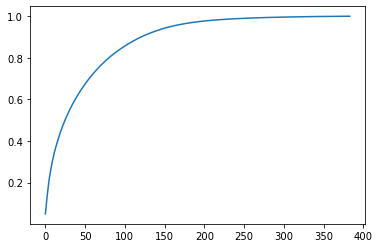

In [50]:
import matplotlib
import matplotlib.pyplot as plt
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(vectors.shape[1]), explained_variance, ls = '-')

In [51]:
# minimal number of components to exceed 95%
comp_num = next(x[0] for x in enumerate(explained_variance) if x[1] > 0.95) + 1
comp_num

159

## 1.2.2 umap to decrease dimensionality [https://arxiv.org/abs/1802.03426 ] (Used with 'rapids' kernel)

In [1]:
import numpy as np

In [121]:
# load dataset after kernel changing
import pandas as pd
df_an = prepare_df()

In [124]:
df_cut = df_an.sample(int(df_an.shape[0]/6), random_state = 2022, ignore_index = True)

In [5]:
VECTOR_PATH = '/mnt/ess_storage/DN_1/storage/home/akorneev/temp_tables/orig_vectors'

In [7]:
# reading
#old_i = 0
#step = 1000000
#vectors_list = list()
#for i in range(step, df_an.shape[0], step):
#    vectors_list.append(np.load(VECTOR_PATH + str(i) + ".npy"))
#vectors_list.append(np.load(VECTOR_PATH + str(df_an.shape[0]) + ".npy"))
#vectors = np.concatenate([ vec for vec in vectors_list ])

vectors = np.load(VECTOR_PATH + '_cut' + ".npy")

In [8]:
vectors.shape

(846239, 384)

In [9]:
# https://docs.rapids.ai/api/cuml/stable/api.html
import cudf
from cuml import UMAP
from cuml.neighbors import NearestNeighbors

In [11]:
# to do: normalize vectors (umap uses euclidean metric)  ->  updated using https://github.com/rapidsai/cuml/issues/1653

In [12]:
comp_num = 159

In [13]:
vectors.shape, type(vectors[0][0]), np.dtype(np.float32).itemsize

((846239, 384), numpy.float32, 4)

In [14]:
a = vectors
a_cudf = cudf.DataFrame(a)

In [15]:
m = NearestNeighbors(n_neighbors=comp_num, metric='cosine')
m.fit(a_cudf)

NearestNeighbors()

In [16]:
knn_graph = m.kneighbors_graph(a_cudf, mode='distance')

In [17]:
u = UMAP(n_components=comp_num)
new_vectors_cudf = u.fit_transform(a_cudf, knn_graph=knn_graph)

In [91]:
new_vectors = new_vectors_cudf.to_numpy()

NameError: name 'new_vectors_cudf' is not defined

In [24]:
UMAP_PATH = '/mnt/ess_storage/DN_1/storage/home/akorneev/temp_tables/umap_vectors'

In [25]:
np.save(UMAP_PATH + '_cut', new_vectors)

In [ ]:
#%%time
#try:
#    new_vectors = np.load(UMAP_PATH)
#except:
#    new_vectors = umap_model.fit_transform(vectors, knn_graph=knn_graph)
#    np.save(UMAP_PATH, new_vectors)

In [94]:
new_vectors.shape

(846239, 159)

## 1.3 vectors clustering to define topics (Used with 'rapids' kernel)

### 1.3.0 Functions to look for key words from clusters

#### 1.3.0.1 Tf-Idf

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer  

transformer = TfidfTransformer()
vectorizer = CountVectorizer()

In [273]:
def get_keywords_from_cluster_tfidf(labels_, df, top_k):
    assert(len(labels_) == df.shape[0])
    print('Labels and df are acceptable')

    try:
        df_an.insert(0, 'label', np.nan)
        print('Column is inserted')
    except:
        print('Label column exists')
    
    for index, row in df.iterrows():
        if index % 100000 == 0:
            print(index, '/', df.shape[0])
        df.at[index, 'label'] = labels_[index]
    # ensure about space in the end in order to use sum()
    df['caption'] = df['caption'] + ' '
    print('Df is updated')

    corpus = list()
    for lab in set(labels_):
        if lab % 10 == 0:
            print('lab', lab, '/', len(set(labels_)))
        corpus.append(str(df[df.label == lab].caption.sum()).lower())

    print('Corpus is ready')
    vec = vectorizer.fit_transform(corpus)

    print('Vectorizer is ready')
    tfidf = transformer.fit_transform(vec)

    print('Finishing...')
    words = vectorizer.get_feature_names_out() 
    weight = tfidf.toarray() 

    for id, lab in enumerate(set(labels_)):
        nums = weight[id].argsort()[-top_k:]
        print("lab", lab, ":", [words[i] for i in nums])
        
    return words, weight

tfidf function testing

In [274]:
d = {'caption': ['I like to eat sushi products animal', 'buy I magazine letter text newspapers', 'Sea products and sushi eat I',
                 'Newspapers and journals buy text', 'sport football in text cup basketball'], 'ran': [3, 4, 4 , 5, 2]}

df1 = pd.DataFrame(data=d)

In [275]:
wo, we = get_keywords_from_cluster_tfidf([0, 1, 0, 1, 2], df1, 3)

Labels and df are acceptable
Label column exists
0 / 5
Df is updated
lab 0 / 3
Corpus is ready
Vectorizer is ready
Finishing...
lab 0 : ['eat', 'products', 'sushi']
lab 1 : ['text', 'buy', 'newspapers']
lab 2 : ['basketball', 'sport', 'in']


In [276]:
pd.DataFrame(we, columns=wo)

,and,animal,basketball,buy,cup,eat,football,in,journals,letter,like,magazine,newspapers,products,sea,sport,sushi,text,to
0,0.186785,0.2456,0.000000,0.000000,0.000000,0.4912,0.000000,0.000000,0.000000,0.000000,0.2456,0.000000,0.000000,0.4912,0.2456,0.000000,0.4912,0.000000,0.2456
1,0.204048,0.0000,0.000000,0.536596,0.000000,0.0000,0.000000,0.000000,0.268298,0.268298,0.0000,0.268298,0.536596,0.0000,0.0000,0.000000,0.0000,0.408095,0.0000
2,0.000000,0.0000,0.423394,0.000000,0.423394,0.0000,0.423394,0.423394,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.423394,0.0000,0.322002,0.0000


#### 1.3.0.2 BERT based cosine similarity approach

In [313]:
from scipy.spatial import distance

In [335]:
def get_keywords_from_cluster_bert(labels_, df, original_vectors, umap_vectors, cluster_centers, top_k):
    #assert(len(labels_) == df.shape[0])
    #print('Labels and df are acceptable')

    assert(len(original_vectors) == len(original_vectors))
    print('Original and UMAP vectors are acceptable')
    
    #try:
    #   df_an.insert(0, 'label', np.nan)
    #    print('Column is inserted')
    #except:
    #    print('Label column exists')
    
    #for index, row in df.iterrows():
    #    if index % 100000 == 0:
    #        print(index, '/', df.shape[0])
    #    df.at[index, 'label'] = labels_[index]
    
    # looking for UMAP vectors, which are closest to cluster central ones
    cluster_center_vectors = dict()
    for cluster_index, cluster_center in enumerate(cluster_centers):
        max_dist = 2
        max_index = 0
        for vector_index, umap_vector in enumerate(umap_vectors):
            dist = distance.cosine(cluster_center, umap_vector)
            if dist < max_dist:
                max_dist = dist
                max_index = vector_index
        cluster_center_vectors[cluster_index] = (max_index, max_dist)
        print('For cluster', cluster_index, ' -> ', cluster_center_vectors[cluster_index])
    
    # obtaining original vectors that corresponds to UMAP vectors
    
    # tokenize captions
    
    # create embedding for each token
    
    # looking for top_k similar tokens to original vectors
    
    return cluster_center_vectors

In [336]:
get_keywords_from_cluster_bert(kmeans_model.labels_, df_cut, vectors, new_vectors, kmeans_model.cluster_centers_, 5)

Original and UMAP vectors are acceptable
For cluster 0  ->  (227650, 0.0018498897552490234)


KeyboardInterrupt: 

In [339]:
new_vectors.shape, vectors.shape, kmeans_model.cluster_centers_.shape, df_cut.shape

((843993, 159), (843993, 384), (100, 159), (843993, 13))

In [341]:
distance.cosine(kmeans_model.cluster_centers_[0], new_vectors[227650]), df_cut.iloc[227650].caption

(0.0018498897552490234,
 '#SedgwickBand @otis_plays_music @theboweryelectric @bridgingthemusic #minifest #rocknroll #blues #musiciansofinstagram #musicianslife #willvaultzphotography')

In [334]:
distance.cosine([1], [-1])

2.0

### 1.3.1 HDBSCAN (to find number of classes)

In [30]:
# HDBSCAN + UMAP https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e
from cuml.cluster import HDBSCAN

In [31]:
hdbscan_model = HDBSCAN(min_cluster_size = 10, max_cluster_size = 20000, metric='euclidean')

In [32]:
%%time
hdbscan_model.fit(new_vectors)

Label prop iterations: 50
Label prop iterations: 8
Label prop iterations: 11
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
32586,438,34102,26,870,62487
Label prop iterations: 2
Iterations: 1
2836,139,4388,14,157,187
CPU times: user 4min 39s, sys: 2min 17s, total: 6min 57s
Wall time: 6min 57s


HDBSCAN()

In [33]:
print("Number of classes:", hdbscan_model.cluster_persistence_[0].shape[0])

Number of classes: 989


In [34]:
unique, counts = np.unique( hdbscan_model.labels_, return_counts=True)
print("Noisy count:", dict(zip(unique, counts))[-1], '/', len(new_vectors))

Noisy count: 664929 / 846239


In [37]:
#dict(zip(unique, counts))

In [23]:
len(df_an), len(hdbscan_model.labels_)

(5077436, 10000)

In [38]:
#set(hdbscan_model.labels_[:10000])

In [38]:
#%%time
# ~1.5 for 30000
# ~3.5 for 50000
#get_keywords_from_cluster(hdbscan_model.labels_, df_an[:10000], 10)

### 1.3.2 K-means

In [39]:
from cuml import KMeans
from cuml.cluster import KMeans

In [40]:
kmeans_model = KMeans( n_clusters = 100 )

In [41]:
kmeans_model.fit(new_vectors)

KMeans()

In [44]:
print("labels:")
print(kmeans_model.labels_)
print("cluster_centers:")
print(kmeans_model.cluster_centers_)

labels:
[16 16 16 ... 16 16 16]
cluster_centers:
[[ -29.631062   -25.952377    13.173149  ...   -3.9463592    7.160551
    -0.6754093]
 [  -1.8572608  -13.249252     3.9118426 ...   -1.0331135    2.4056315
    -1.5349947]
 [ 212.59457   -200.68294   -211.7191    ...  170.304      210.60962
  -179.27914  ]
 ...
 [ -26.967728   -32.44268     31.338455  ...   29.954788   -25.900599
    31.002636 ]
 [ -61.271828    45.47111     60.244064  ...  -41.965828   -34.58024
    40.815666 ]
 [  11.210983    12.296383   -21.038128  ...  -26.82217     16.835262
    30.25371  ]]


In [49]:
kmeans_model.labels_

array([16, 16, 16, ..., 16, 16, 16], dtype=int32)

In [54]:
unique, counts = np.unique( kmeans_model.labels_, return_counts=True)
dict_clus_num = dict(zip(unique, counts))
dict_clus_num

{0: 1,
 1: 65,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 40,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 107,
 16: 845929,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 3,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1}

#### 1.3.2.1 Looking for outliers using K-means clusters with small size

In [106]:
def get_outliers(labels, min_cluster_size = 10):
    unique, counts = np.unique( labels, return_counts=True)
    dict_clus_num = dict(zip(unique, counts))
    
    outliers = [ id for id, lab in enumerate(labels) if dict_clus_num[lab] < min_cluster_size ]
    
    return outliers

In [297]:
new_vectors = new_vectors_backup
vectors = vectors_backup
df_cut = df_cut_backup.copy()
df_cut.shape, new_vectors.shape, vectors.shape

((846239, 12), (846239, 159), (846239, 384))

In [288]:
vectors_backup = vectors

In [96]:
new_vectors_backup = new_vectors

In [125]:
df_cut_backup = df_cut.copy()

In [298]:
%%time
i = 0
while( True ):
    print('Iteration', i)
    
    kmeans_model = KMeans( n_clusters = 100 )
    kmeans_model.fit(new_vectors)
    
    outl = get_outliers(kmeans_model.labels_)

    if len(outl) != 0:
        print('delete ', len(outl), ' vectors \ rows')
        new_vectors = np.delete(new_vectors, outl, 0)
        vectors = np.delete(vectors, outl, 0)
        df_cut = df_cut.drop(outl).reset_index().drop('index', axis = 1)
        i += 1
    else:
        print('break')
        break

Iteration 0
delete  98  vectors \ rows
Iteration 1
delete  97  vectors \ rows
Iteration 2
delete  98  vectors \ rows
Iteration 3
delete  100  vectors \ rows
Iteration 4
delete  91  vectors \ rows
Iteration 5
delete  104  vectors \ rows
Iteration 6
delete  99  vectors \ rows
Iteration 7
delete  98  vectors \ rows
Iteration 8
delete  99  vectors \ rows
Iteration 9
delete  98  vectors \ rows
Iteration 10
delete  99  vectors \ rows
Iteration 11
delete  99  vectors \ rows
Iteration 12
delete  99  vectors \ rows
Iteration 13
delete  105  vectors \ rows
Iteration 14
delete  99  vectors \ rows
Iteration 15
delete  98  vectors \ rows
Iteration 16
delete  99  vectors \ rows
Iteration 17
delete  99  vectors \ rows
Iteration 18
delete  99  vectors \ rows
Iteration 19
delete  98  vectors \ rows
Iteration 20
delete  98  vectors \ rows
Iteration 21
delete  97  vectors \ rows
Iteration 22
delete  42  vectors \ rows
Iteration 23
delete  23  vectors \ rows
Iteration 24
delete  7  vectors \ rows
Iteratio

In [300]:
print( - len(new_vectors) + len(new_vectors_backup), ' elements are deleted')

2246  elements are deleted


In [302]:
kmeans_model = KMeans( n_clusters = 100 )
kmeans_model.fit(new_vectors)

KMeans()

In [303]:
unique, counts = np.unique( kmeans_model.labels_, return_counts=True)
dict_clus_num = dict(zip(unique, counts))
dict_clus_num

{0: 17640,
 1: 2423,
 2: 11017,
 3: 11775,
 4: 7666,
 5: 2161,
 6: 2721,
 7: 11770,
 8: 2600,
 9: 13610,
 10: 14756,
 11: 1669,
 12: 5054,
 13: 14217,
 14: 10452,
 15: 8672,
 16: 7598,
 17: 5084,
 18: 12956,
 19: 9506,
 20: 1105,
 21: 3102,
 22: 13450,
 23: 11744,
 24: 18537,
 25: 4097,
 26: 8999,
 27: 11414,
 28: 8347,
 29: 12463,
 30: 6888,
 31: 17636,
 32: 12288,
 33: 3515,
 34: 7365,
 35: 6334,
 36: 8845,
 37: 3705,
 38: 2442,
 39: 10910,
 40: 11534,
 41: 18042,
 42: 20565,
 43: 18696,
 44: 8926,
 45: 218,
 46: 13850,
 47: 18482,
 48: 6339,
 49: 7405,
 50: 294,
 51: 8943,
 52: 11065,
 53: 9604,
 54: 6601,
 55: 544,
 56: 7342,
 57: 6227,
 58: 11999,
 59: 9237,
 60: 2267,
 61: 7853,
 62: 164,
 63: 9861,
 64: 12653,
 65: 13051,
 66: 4666,
 67: 12274,
 68: 5783,
 69: 10404,
 70: 12677,
 71: 73,
 72: 18885,
 73: 3776,
 74: 8291,
 75: 15626,
 76: 6133,
 77: 2633,
 78: 12308,
 79: 11090,
 80: 13080,
 81: 7119,
 82: 14741,
 83: 13171,
 84: 8889,
 85: 2498,
 86: 362,
 87: 188,
 88: 6659,
 8

In [304]:
#get_keywords_from_cluster_tfidf(kmeans_model.labels_, df_cut, 10)

### 1.3.3 Agglomerative Clustering

## 1.4 quantization analysis for obtained clusters

# 2. Similarity calculating

In [24]:
def connect_time(time1, time2):
    # check wich cluster it is, chose time shift
    return 0.5

In [25]:
def connect_space(space1, space2):
    # check wich cluster it is, chose space shift
    return 0.5

In [23]:
def connect_semantic(text1, text2):
    return 0.5

In [28]:
def get_similarity(row1, row2):
    # + реклама
    total = connect_time(row1.timestamp, row2.timestamp) + connect_space((row1.lat, row1.lon), (row2.lat, row2.lon)) + connect_semantic(row1.caption, row2.caption)
    return float (total) / 3

In [32]:
get_similarity(df_an.iloc[0], df_an.iloc[1])

0.5

# 3. Testing

In [ ]:
# граф со связкой аномалий?